In [1]:
import pandas as pd
import numpy as np
import time

from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

In [2]:
dfAdult = pd.read_csv(".\\data\\adult.csv")

result_dict = {}
np.random.seed =10

# reshuffle input data ..good thing for neural netwrok
#dfAdult = dfAdult.sample(frac=1).reset_index(drop=True) 
dfAdultWithoutSalary = dfAdult.drop(columns=['salary'])
dfAdultHotEncoded = pd.get_dummies(dfAdult,columns=['salary','education','workclass','occupation','relationship','marital-status','race','sex'])
dfAdultHotEncoded = dfAdultHotEncoded.drop(columns=['salary_ <=50K','native-country'])
X_HotEncoded = dfAdultHotEncoded.drop('salary_ >50K',axis=1)
Y_HotEncoded = dfAdultHotEncoded['salary_ >50K']

X_HotEncoded_NumOfFeatures = len(list(X_HotEncoded.columns))

label_encoding = preprocessing.LabelEncoder()
dfAdult['salary'] = label_encoding.fit_transform(dfAdult['salary'])
dfAdult['education'] = label_encoding.fit_transform(dfAdult['education'])
dfAdult['workclass'] = label_encoding.fit_transform(dfAdult['workclass'])
dfAdult['occupation'] = label_encoding.fit_transform(dfAdult['occupation'])
dfAdult['relationship'] = label_encoding.fit_transform(dfAdult['relationship'])
dfAdult['marital-status'] = label_encoding.fit_transform(dfAdult['marital-status'])
dfAdult['race'] = label_encoding.fit_transform(dfAdult['race'])
dfAdult['sex'] = label_encoding.fit_transform(dfAdult['sex'])
dfAdult['native-country']=label_encoding.fit_transform(dfAdult['native-country'])

X = dfAdult.drop('salary',axis=1)
Y = dfAdult['salary']
X_LabelEncoded_NumOfFeatures = len(list(X.columns))
print(X.columns)
print(X.shape)



print(X_HotEncoded.columns)
print(X_HotEncoded.shape)
#X=X_HotEncoded
#Y=Y_HotEncoded
#X = X[:, None]


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
(32561, 14)
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'education_ 10th', 'education_ 11th',
       'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th',
       'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm',
       'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate',
       'education_ HS-grad', 'education_ Masters', 'education_ Preschool',
       'education_ Prof-school', 'education_ Some-college', 'workclass_ ?',
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'occupatio

In [3]:
def PCA_EM(data,i):
        model = PCA(n_components=i)        
        data_new = model.fit_transform(data)
        return data_new

In [4]:
def ICA_EM(data,i):
        model = FastICA(n_components=i,max_iter=10000,tol=0.01)        
        data_new = model.fit_transform(data)
        return data_new

In [5]:
def RP_EM(data,i):
        model = GaussianRandomProjection(n_components=i)
        data_new = model.fit_transform(data)
        return data_new

In [3]:
def LDA_EM(data,groundtruth):
        model = LinearDiscriminantAnalysis(n_components=1)
        data_new = model.fit(data,groundtruth).transform(data)
        return data_new

In [4]:
def summarise_classification(Y_test,Y_pred):
    
    acc = accuracy_score(Y_test,Y_pred,normalize=True)
    prec = precision_score(Y_test,Y_pred)
    rec = recall_score(Y_test,Y_pred)
    roc = roc_auc_score(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    acc_count = accuracy_score(Y_test,Y_pred,normalize=False)
    model_crosstab = pd.crosstab(Y_test,Y_pred)
    return {'accuracy':acc,'precision':prec,'recall':rec ,'AUC':roc,'accuracy_count':acc_count,'r2Score':r2,'mean_squared_error':mse,'confusionmatrix':model_crosstab}


In [5]:
def buildModel(class_fn,X,Y,test_frac=0.2):
        
    X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=test_frac)
    model = class_fn(X_train,Y_train)
    
    Y_pred = model.predict(X_test)
    
    Y_pred_train = model.predict(X_train)
    train_summary = summarise_classification(Y_train,Y_pred_train)
    test_summary = summarise_classification( Y_test,Y_pred)
    
    pred_result = pd.DataFrame({'Y_test':Y_test,'Y_pred':Y_pred})    
    
    
    return model,{'training':train_summary,'test':test_summary}

In [6]:
def compare_results(key1):
    for key in result_dict:
        if(key==key1):
            print ('Classification: ',key)
            print()
            print('Training data')
            for scorekey in result_dict[key]['training']:
                print(scorekey,': ',result_dict[key]['training'][scorekey])

            print()
            print('Test data')
            for scorekey in result_dict[key]['test']:
                print(scorekey, ': ' ,result_dict[key]['test'][scorekey])
        
        print()   

In [7]:
def classifier_fn(x_train,y_train):
    model = MLPClassifier(hidden_layer_sizes =5,max_iter=60000)   
    start_time = time.time()
    model.fit(x_train,y_train)
    print("training time base model: ",(time.time() - start_time) ," seconds")
    
    return model

In [8]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores= \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #fit_times_mean = np.mean(fit_times, axis=1)
    #fit_times_std = np.std(fit_times, axis=1)
  
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    """
    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    """
    return plt

training time base model:  594.2095849514008  seconds
Classification:  MLPClassifier_Adult_Original

Training data
accuracy :  0.8000614250614251
precision :  0.8731343283582089
recall :  0.20402663284717817
AUC :  0.5972767409423327
accuracy_count :  20840
r2Score :  -0.08944804975782183
mean_squared_error :  0.19993857493857495
confusionmatrix :  col_0             0     1
salary_ >50K             
0             19553   187
1              5021  1287

Test data
accuracy :  0.8040841394134808
precision :  0.8337662337662337
recall :  0.20939334637964774
AUC :  0.5982709703785789
accuracy_count :  5237
r2Score :  -0.08857975935051354
mean_squared_error :  0.19591586058651927
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4916   64
1             1212  321



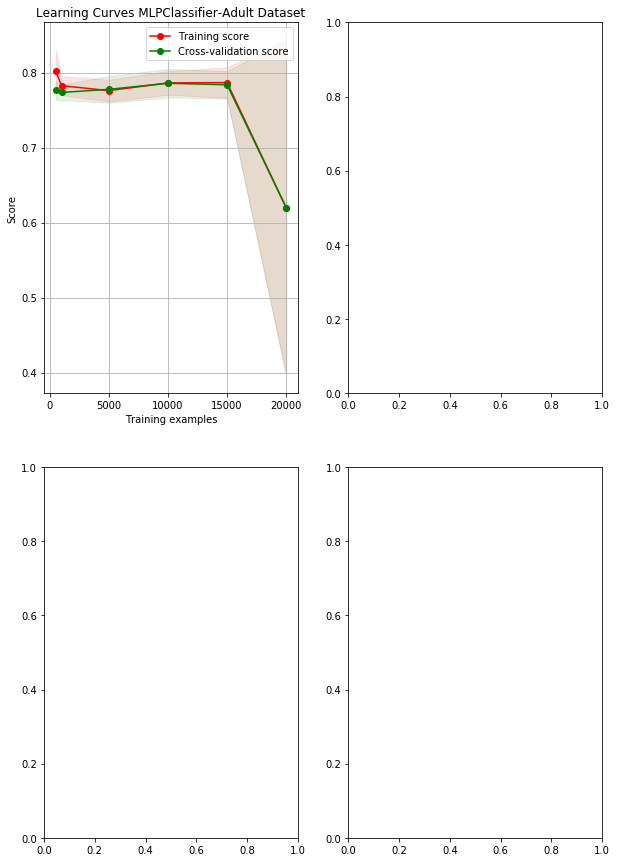

In [12]:
#ADULT Original_NN
key1="MLPClassifier_Adult_Original"
model,result_dict[key1] = buildModel(classifier_fn,X_HotEncoded,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult Dataset"

plot_learning_curve(model, title, X, Y, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  215.00563836097717  seconds

Classification:  MLPClassifier_Adult_PCA

Training data
accuracy :  0.7758369164619164
precision :  0.8237037037037037
recall :  0.08859145952836202
AUC :  0.5412864236747617
accuracy_count :  20209
r2Score :  -0.2256862715517769
mean_squared_error :  0.22416308353808354
confusionmatrix :  col_0             0    1
salary_ >50K            
0             19653  119
1              5720  556

Test data
accuracy :  0.7773683402425917
precision :  0.8362573099415205
recall :  0.09137380191693291
AUC :  0.542857474927747
accuracy_count :  5063
r2Score :  -0.21956526792378717
mean_squared_error :  0.22263165975740826
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4920   28
1             1422  143



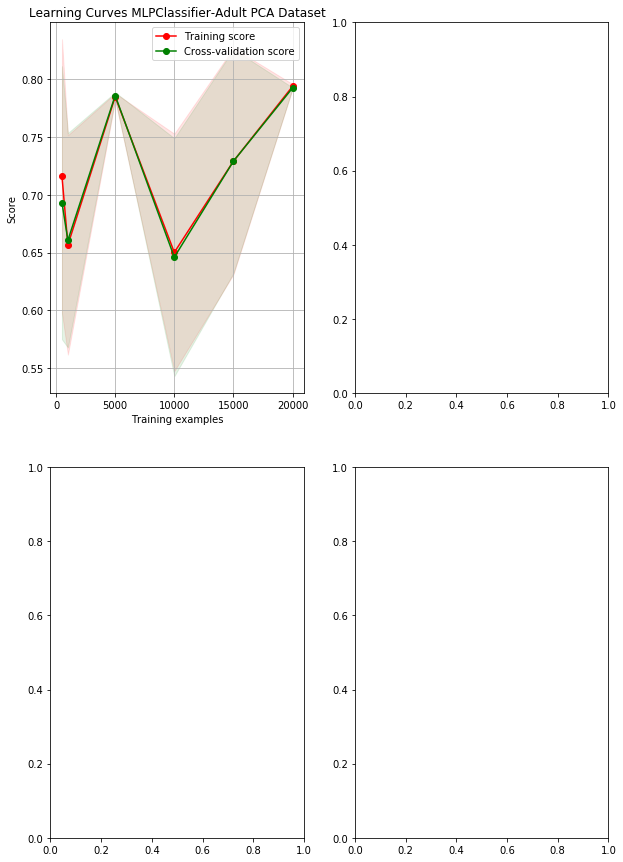

In [13]:
#ADULT PCA_NN
data_new = PCA_EM(X_HotEncoded,2)
key1="MLPClassifier_Adult_PCA"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult PCA Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  5.91093635559082  seconds


Classification:  MLPClassifier_Adult_ICA

Training data
accuracy :  0.8004453316953317
precision :  0.9364575059571089
recall :  0.18723201524535493
AUC :  0.591590793709458
accuracy_count :  20850
r2Score :  -0.08864899521996272
mean_squared_error :  0.1995546683046683
confusionmatrix :  col_0             0     1
salary_ >50K             
0             19671    80
1              5118  1179

Test data
accuracy :  0.8057730692461231
precision :  0.9400630914826499
recall :  0.19300518134715025
AUC :  0.5945907371819269
accuracy_count :  5248
r2Score :  -0.07387890412787246
mean_squared_error :  0.19422693075387687
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4950   19
1             1246  298



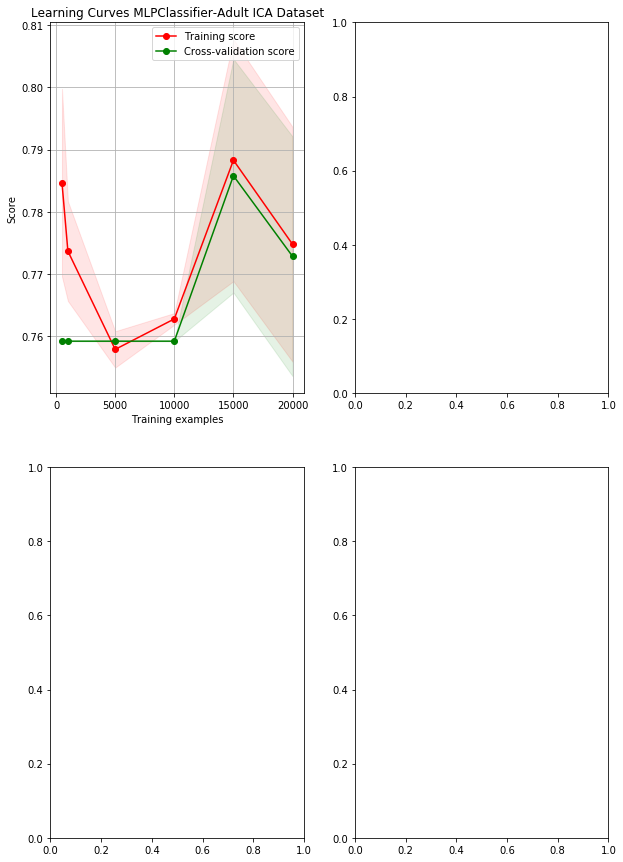

In [14]:
#ADULT ICA_NN
data_new = ICA_EM(X_HotEncoded,2)
key1="MLPClassifier_Adult_ICA"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult ICA Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  54.98815608024597  seconds



Classification:  MLPClassifier_Adult_RP

Training data
accuracy :  0.7964910933660934
precision :  0.8093730208993034
recall :  0.2035680152914941
AUC :  0.5941714633867688
accuracy_count :  20747
r2Score :  -0.11251072584804889
mean_squared_error :  0.20350890663390664
confusionmatrix :  col_0             0     1
salary_ >50K             
0             19469   301
1              5000  1278

Test data
accuracy :  0.7968678028558268
precision :  0.8174603174603174
recall :  0.19769673704414586
AUC :  0.591878671552376
accuracy_count :  5190
r2Score :  -0.11372186354911906
mean_squared_error :  0.2031321971441732
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4881   69
1             1254  309



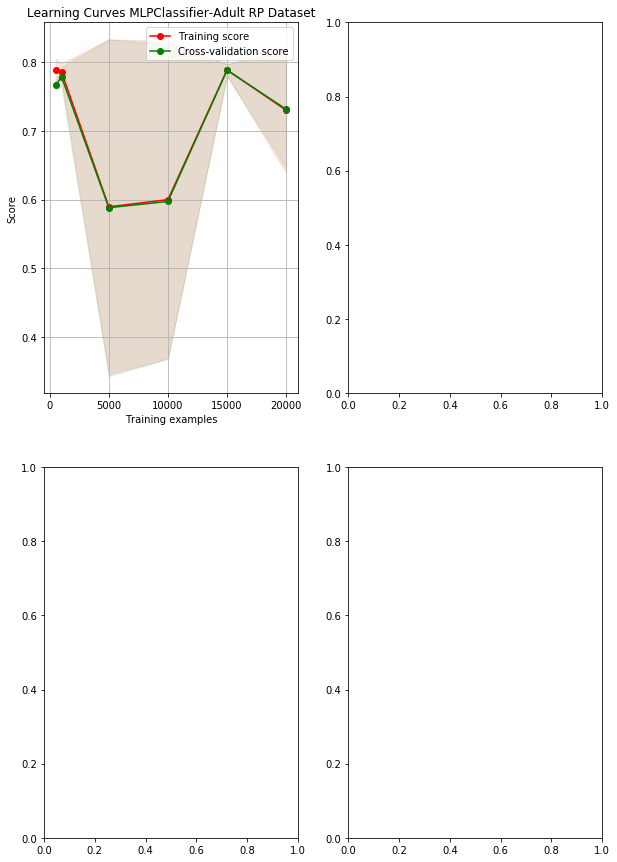

In [16]:
#ADULT RP_NN
data_new = RP_EM(X_HotEncoded,3)
key1="MLPClassifier_Adult_RP"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult RP Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  6.047814846038818  seconds
Classification:  MLPClassifier_Adult_LDA

Training data
accuracy :  0.8402948402948403
precision :  0.7097984986171474
recall :  0.571769573520051
AUC :  0.748721257110157
accuracy_count :  21888
r2Score :  0.12751756532300773
mean_squared_error :  0.1597051597051597
confusionmatrix :  col_0             0     1
salary_ >50K             
0             18295  1469
1              2691  3593

Test data
accuracy :  0.8432366037156457
precision :  0.7130365659777425
recall :  0.5761078998073218
AUC :  0.7516334495001097
accuracy_count :  5492
r2Score :  0.13823885257705226
mean_squared_error :  0.15676339628435437
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4595  361
1              660  897



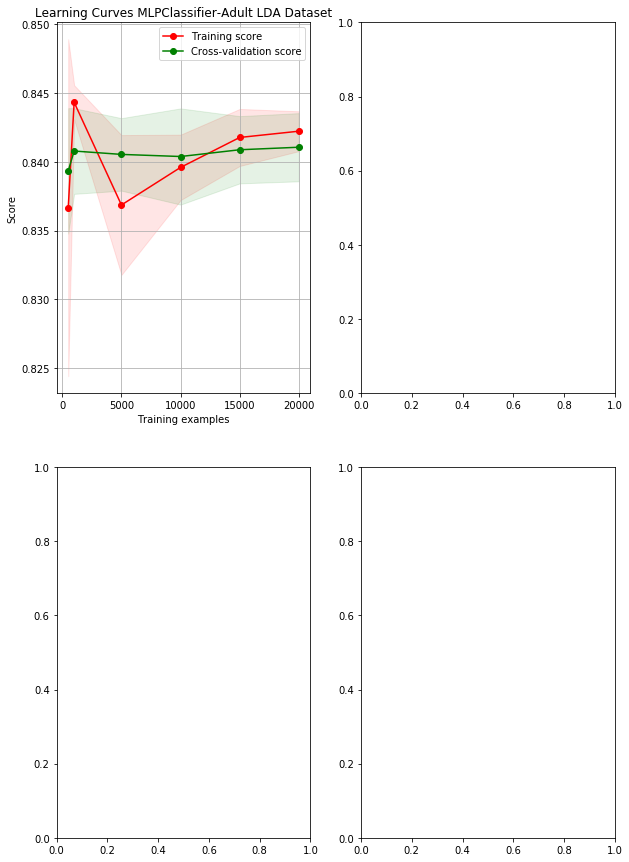

In [9]:
#ADULT LDA_KMEANS
data_new = LDA_EM(X_HotEncoded,Y_HotEncoded)
key1="MLPClassifier_Adult_LDA"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult LDA Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()